# homework 8
## question 1
Get the country-specific covid case data from here (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv). (Note pandas allows you to load a csv file from a URL. Make sure to use the "raw" link to the file on github.). Pick a country. Let  𝑌𝑡  be the case count for day  𝑡  since the outbreak onset for that country. That is, process the time series so that  𝑡=0  is the first day with more than 0 cases. Then, fit a distributed lag linear model as follows.
𝑌𝑡=𝛼0+𝛽1𝑌𝑡−1+𝛽2𝑌𝑡−2+…+𝛽𝑘𝑌𝑡−5+𝜖𝑡 
That is, see how the last five days predicts the current day. Report and interpret the coefficients.

In [1]:
import requests
from io import StringIO
import pandas as pd
from sklearn.linear_model import LinearRegression


In [2]:
#raw data url: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
response = requests.get(url)
coviddf = pd.read_csv(StringIO(response.text))

#drop columns not needed
coviddf = coviddf.drop(columns=['Province/State', 'Lat', 'Long'])

print(coviddf)
print(coviddf.columns)

           Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0             Afghanistan        0        0        0        0        0   
1                 Albania        0        0        0        0        0   
2                 Algeria        0        0        0        0        0   
3                 Andorra        0        0        0        0        0   
4                  Angola        0        0        0        0        0   
..                    ...      ...      ...      ...      ...      ...   
284    West Bank and Gaza        0        0        0        0        0   
285  Winter Olympics 2022        0        0        0        0        0   
286                 Yemen        0        0        0        0        0   
287                Zambia        0        0        0        0        0   
288              Zimbabwe        0        0        0        0        0   

     1/27/20  1/28/20  1/29/20  1/30/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0          0        0        0

first need to make data set long - currently column = individual date, row = case count

In [3]:
# reshape dataframe to long format
coviddf_long = coviddf.melt(
    id_vars=['Country/Region'],
    var_name ='date',
    value_name ='cases'
)

coviddf_long.head(100)

# Filter for Ireland
ireland_df = coviddf_long[coviddf_long['Country/Region'] == 'Ireland']

ireland_df.head(100)
print(ireland_df)

# Convert the 'date' column to a datetime object for easier handling
ireland_df['date'] = pd.to_datetime(ireland_df['date'])

# Filter to start at the first day with more than 0 cases
ireland_df = ireland_df[ireland_df['cases'] > 0].reset_index(drop=True)

# Add a new column for t (days since the first case)
ireland_df['t'] = (ireland_df['date'] - ireland_df['date'].min()).dt.days

# Display the processed DataFrame
print(ireland_df)

# create lagged variables
for lag in range(1, 6):  # Create lags for the last 5 days
    ireland_df[f'lag_{lag}'] = ireland_df['cases'].shift(lag)

# Drop rows with NaN values caused by lagging
ireland_df = ireland_df.dropna().reset_index(drop=True)

# Define the predictor variables (lags) and the target variable (current cases)
X = ireland_df[[f'lag_{lag}' for lag in range(1, 6)]]
y = ireland_df['cases']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept
intercept = model.intercept_
coefficients = model.coef_

# Print the results
print("Intercept (α₀):", intercept)
for i, coef in enumerate(coefficients, start=1):
    print(f"Coefficient for Y_t-{i} (β{i}):", coef)

       Country/Region     date    cases
152           Ireland  1/22/20        0
441           Ireland  1/23/20        0
730           Ireland  1/24/20        0
1019          Ireland  1/25/20        0
1308          Ireland  1/26/20        0
...               ...      ...      ...
329034        Ireland   3/5/23  1703850
329323        Ireland   3/6/23  1703850
329612        Ireland   3/7/23  1703850
329901        Ireland   3/8/23  1704502
330190        Ireland   3/9/23  1704502

[1143 rows x 3 columns]
     Country/Region       date    cases     t
0           Ireland 2020-02-29        1     0
1           Ireland 2020-03-01        1     1
2           Ireland 2020-03-02        1     2
3           Ireland 2020-03-03        2     3
4           Ireland 2020-03-04        6     4
...             ...        ...      ...   ...
1100        Ireland 2023-03-05  1703850  1100
1101        Ireland 2023-03-06  1703850  1101
1102        Ireland 2023-03-07  1703850  1102
1103        Ireland 2023-03-08  170

/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/1810926242.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ireland_df['date'] = pd.to_datetime(ireland_df['date'])
/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/1810926242.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland_df['date'] = pd.to_datetime(ireland_df['date'])


### interpretation

Interpret the Coefficients
**definitions**
Intercept (( \alpha_0 )): Represents the baseline case count when all lagged values are 0.

Coefficients (( \beta_1, \beta_2, \dots, \beta_5 )): Represent the contribution of the case counts from the past 1 to 5 days to the current day's case count.

For example:
( \beta_1 ): How much ( Y_{t-1} ) (yesterday's cases) contributes to today's cases.
( \beta_2 ): How much ( Y_{t-2} ) (two days ago) contributes, and so on.

### my data
baseline is 206.25 when all lagged values are zero *unlikely that all lagged values would be zero, more likely a mathematical artifact than a meaningful value*

ß1 = 1.12: current day's count increases by approx 1.12 cases
    strong positive coefiicent suggest previous days count has largest influence on current day's count

ß2 = 0.09: for every 1 additional case 2 days ago the current case count increases by 0.09 cases
    much smaller positive influence, impact of case diminishes as lag increases

ß3 = 0.10: similar effect as ß2 (which is to say not much)

ß4 = -0.10: negative coefficient suggests cases from four days ago have slight inverse relationship with current day's cases

ß5 = -0.22: similar to ß4 but stronger
    more signficant inverse relationship with current day's cases


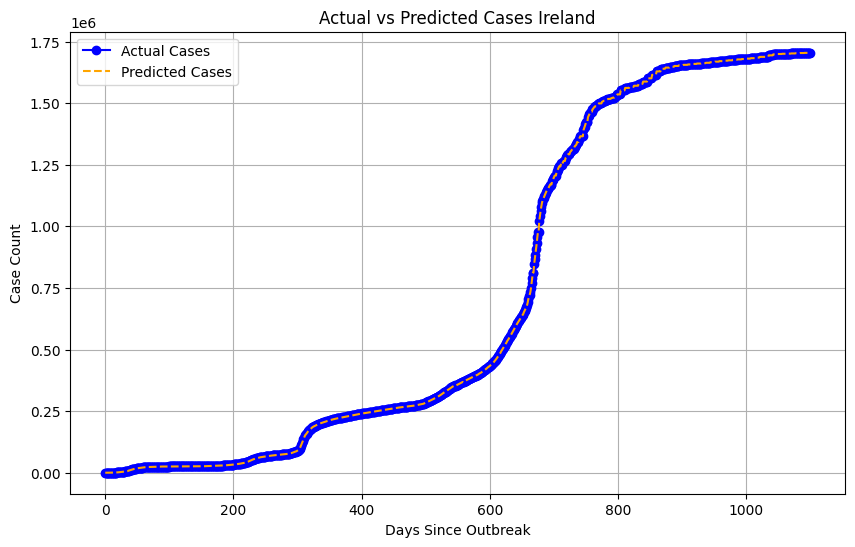

In [4]:
# visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ireland_df['cases'], label='Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['cases'], label='Predicted Cases', color='orange', linestyle='--')
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases Ireland')
plt.legend()
plt.grid(True)
plt.show()

# Question 2
Refer to the previous question. Let A and B be your two countries. Create a plot of time versus prediction error for the following: a. fit the model on (all of) A and apply it to (all of) A to get the mean squared error, b. fit A on the first half of the time for A, apply it to the second half of A to get the mean squared error.


In [5]:
## create country B (Russia)
# Filter for Russia
russia_df = coviddf_long[coviddf_long['Country/Region'] == 'Russia']

russia_df.head(100)
print(russia_df)

# Convert the 'date' column to a datetime object for easier handling
russia_df['date'] = pd.to_datetime(russia_df['date'])

# Filter to start at the first day with more than 0 cases
russia_df = russia_df[russia_df['cases'] > 0].reset_index(drop=True)

# Add a new column for t (days since the first case)
russia_df['t'] = (russia_df['date'] - russia_df['date'].min()).dt.days

# Display the processed DataFrame
print(russia_df)
# create lagged variables
for lag in range(1, 6):  # Create lags for the last 5 days
    russia_df[f'lag_{lag}'] = russia_df['cases'].shift(lag)

# Drop rows with NaN values caused by lagging
russia_df = russia_df.dropna().reset_index(drop=True)
from sklearn.linear_model import LinearRegression
import numpy as np


       Country/Region     date     cases
221            Russia  1/22/20         0
510            Russia  1/23/20         0
799            Russia  1/24/20         0
1088           Russia  1/25/20         0
1377           Russia  1/26/20         0
...               ...      ...       ...
329103         Russia   3/5/23  22029824
329392         Russia   3/6/23  22040875
329681         Russia   3/7/23  22051220
329970         Russia   3/8/23  22063473
330259         Russia   3/9/23  22075858

[1143 rows x 3 columns]
     Country/Region       date     cases     t
0            Russia 2020-01-31         2     0
1            Russia 2020-02-01         2     1
2            Russia 2020-02-02         2     2
3            Russia 2020-02-03         2     3
4            Russia 2020-02-04         2     4
...             ...        ...       ...   ...
1129         Russia 2023-03-05  22029824  1129
1130         Russia 2023-03-06  22040875  1130
1131         Russia 2023-03-07  22051220  1131
1132         

/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/71242662.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  russia_df['date'] = pd.to_datetime(russia_df['date'])
/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/71242662.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russia_df['date'] = pd.to_datetime(russia_df['date'])


Intercept (α₀): 153.35229543969035
Coefficient for Y_t-1 (β1): 2.5672618921078474
Coefficient for Y_t-2 (β2): -2.3108890914385816
Coefficient for Y_t-3 (β3): 1.026688200669127
Coefficient for Y_t-4 (β4): -0.3949972966496366
Coefficient for Y_t-5 (β5): 0.11193136562422118


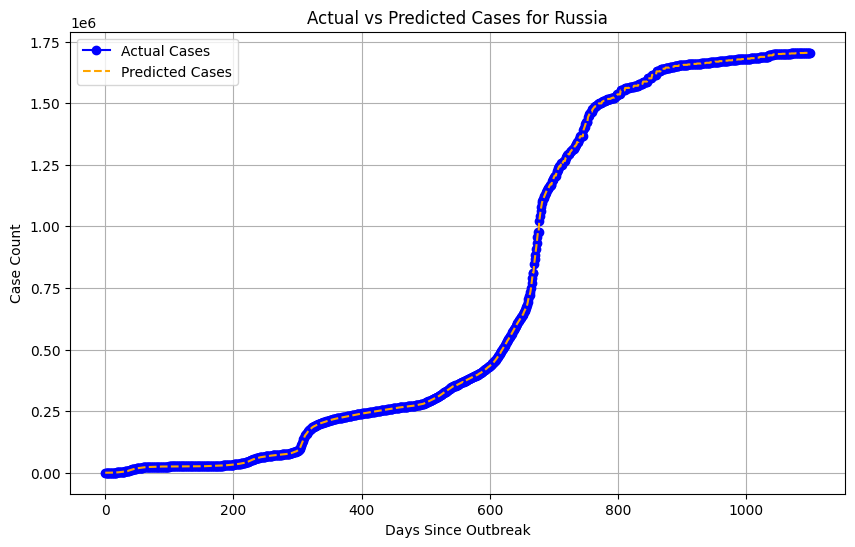

In [7]:
# Define the predictor variables (lags) and the target variable (current cases)
X = russia_df[[f'lag_{lag}' for lag in range(1, 6)]]
y = russia_df['cases']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept
intercept = model.intercept_
coefficients = model.coef_

# Print the results
print("Intercept (α₀):", intercept)
for i, coef in enumerate(coefficients, start=1):
    print(f"Coefficient for Y_t-{i} (β{i}):", coef)
# visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ireland_df['cases'], label='Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['cases'], label='Predicted Cases', color='orange', linestyle='--')
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases for Russia')
plt.legend()
plt.grid(True)
plt.show()


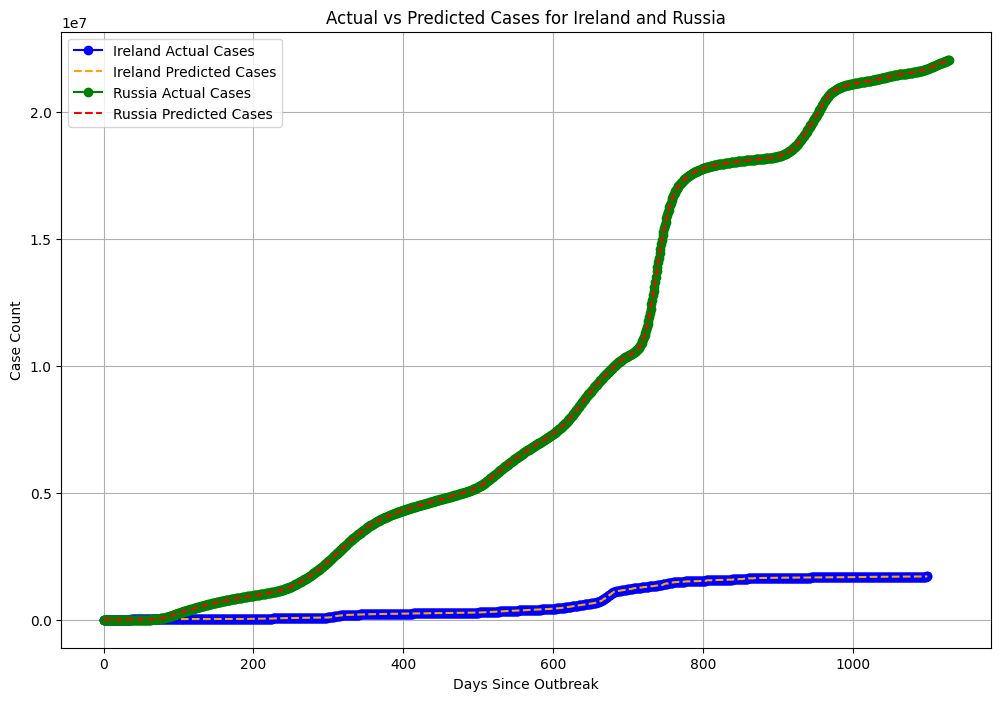

In [53]:
# ireland and russia
import matplotlib.pyplot as plt

# Plot actual cases for both countries
plt.figure(figsize=(12, 8))
plt.plot(ireland_df['cases'], label='Ireland Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['predicted_cases'], label='Ireland Predicted Cases', color='orange', linestyle='--')
plt.plot(russia_df['cases'], label='Russia Actual Cases', color='green', marker='o')
plt.plot(russia_df['cases'], label='Russia Predicted Cases', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases for Ireland and Russia')
plt.legend()
plt.grid(True)
plt.show()

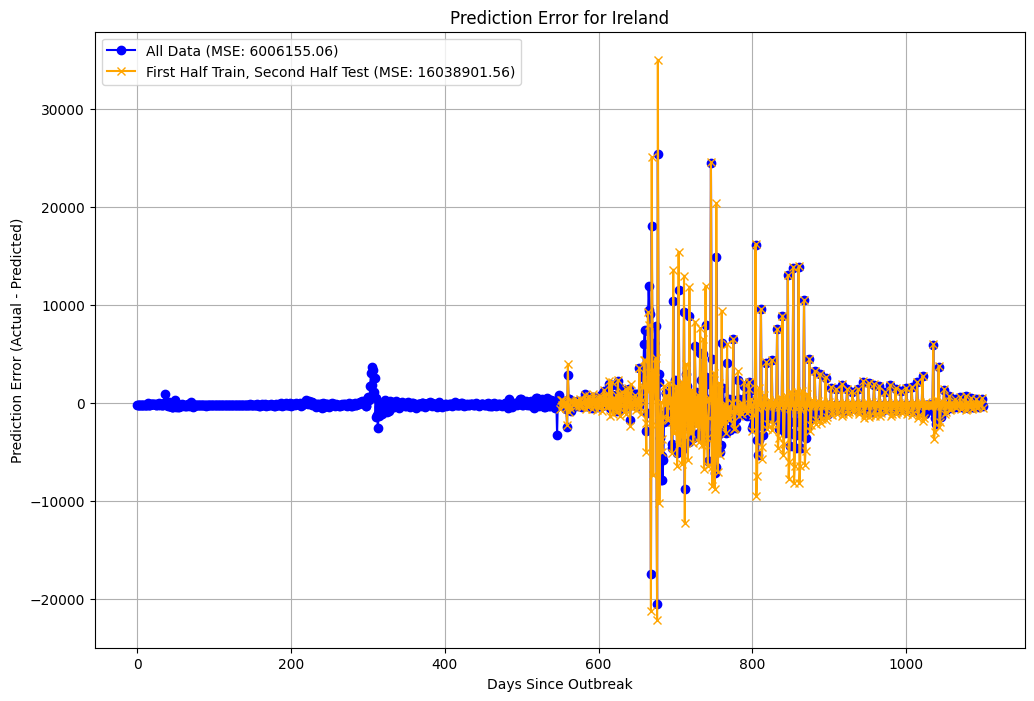

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function to calculate prediction error and MSE
def calculate_prediction_error(df, X_columns, y_column, train_indices, test_indices):
    # Split the data into training and testing sets
    X_train = df.loc[train_indices, X_columns]
    y_train = df.loc[train_indices, y_column]
    X_test = df.loc[test_indices, X_columns]
    y_test = df.loc[test_indices, y_column]
    
    # Fit the model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate prediction error and MSE
    prediction_error = y_test - y_pred
    mse = mean_squared_error(y_test, y_pred)
    
    return prediction_error, mse

# Define the lagged variables and target variable
X_columns = [f'lag_{lag}' for lag in range(1, 6)]
y_column = 'cases'

# Case a: Fit the model on all of Ireland's data
all_indices = ireland_df.index
prediction_error_all, mse_all = calculate_prediction_error(ireland_df, X_columns, y_column, all_indices, all_indices)

# Case b: Fit the model on the first half of Ireland's data and apply it to the second half
split_index = len(ireland_df) // 2
train_indices = ireland_df.index[:split_index]
test_indices = ireland_df.index[split_index:]
prediction_error_half, mse_half = calculate_prediction_error(ireland_df, X_columns, y_column, train_indices, test_indices)

# Plot the prediction errors
plt.figure(figsize=(12, 8))

# Plot prediction error for Case a
plt.plot(all_indices, prediction_error_all, label=f'All Data (MSE: {mse_all:.2f})', color='blue', marker='o')

# Plot prediction error for Case b
plt.plot(test_indices, prediction_error_half, label=f'First Half Train, Second Half Test (MSE: {mse_half:.2f})', color='orange', marker='x')

# Add labels, title, and legend
plt.xlabel('Days Since Outbreak')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.title('Prediction Error for Ireland')
plt.legend()
plt.grid(True)
plt.show()

# homework 8
## question 1
Get the country-specific covid case data from here (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv). (Note pandas allows you to load a csv file from a URL. Make sure to use the "raw" link to the file on github.). Pick a country. Let  𝑌𝑡  be the case count for day  𝑡  since the outbreak onset for that country. That is, process the time series so that  𝑡=0  is the first day with more than 0 cases. Then, fit a distributed lag linear model as follows.
𝑌𝑡=𝛼0+𝛽1𝑌𝑡−1+𝛽2𝑌𝑡−2+…+𝛽𝑘𝑌𝑡−5+𝜖𝑡 
That is, see how the last five days predicts the current day. Report and interpret the coefficients.

In [9]:
import requests
from io import StringIO
import pandas as pd
from sklearn.linear_model import LinearRegression


In [10]:
#raw data url: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
response = requests.get(url)
coviddf = pd.read_csv(StringIO(response.text))

#drop columns not needed
coviddf = coviddf.drop(columns=['Province/State', 'Lat', 'Long'])

print(coviddf)
print(coviddf.columns)

           Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0             Afghanistan        0        0        0        0        0   
1                 Albania        0        0        0        0        0   
2                 Algeria        0        0        0        0        0   
3                 Andorra        0        0        0        0        0   
4                  Angola        0        0        0        0        0   
..                    ...      ...      ...      ...      ...      ...   
284    West Bank and Gaza        0        0        0        0        0   
285  Winter Olympics 2022        0        0        0        0        0   
286                 Yemen        0        0        0        0        0   
287                Zambia        0        0        0        0        0   
288              Zimbabwe        0        0        0        0        0   

     1/27/20  1/28/20  1/29/20  1/30/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0          0        0        0

first need to make data set long - currently column = individual date, row = case count

In [11]:
# reshape dataframe to long format
coviddf_long = coviddf.melt(
    id_vars=['Country/Region'],
    var_name ='date',
    value_name ='cases'
)

coviddf_long.head(100)

# Filter for Ireland
ireland_df = coviddf_long[coviddf_long['Country/Region'] == 'Ireland']

ireland_df.head(100)
print(ireland_df)

# Convert the 'date' column to a datetime object for easier handling
ireland_df['date'] = pd.to_datetime(ireland_df['date'])

# Filter to start at the first day with more than 0 cases
ireland_df = ireland_df[ireland_df['cases'] > 0].reset_index(drop=True)

# Add a new column for t (days since the first case)
ireland_df['t'] = (ireland_df['date'] - ireland_df['date'].min()).dt.days

# Display the processed DataFrame
print(ireland_df)

# create lagged variables
for lag in range(1, 6):  # Create lags for the last 5 days
    ireland_df[f'lag_{lag}'] = ireland_df['cases'].shift(lag)

# Drop rows with NaN values caused by lagging
ireland_df = ireland_df.dropna().reset_index(drop=True)

# Define the predictor variables (lags) and the target variable (current cases)
X = ireland_df[[f'lag_{lag}' for lag in range(1, 6)]]
y = ireland_df['cases']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept
intercept = model.intercept_
coefficients = model.coef_

# Print the results
print("Intercept (α₀):", intercept)
for i, coef in enumerate(coefficients, start=1):
    print(f"Coefficient for Y_t-{i} (β{i}):", coef)

       Country/Region     date    cases
152           Ireland  1/22/20        0
441           Ireland  1/23/20        0
730           Ireland  1/24/20        0
1019          Ireland  1/25/20        0
1308          Ireland  1/26/20        0
...               ...      ...      ...
329034        Ireland   3/5/23  1703850
329323        Ireland   3/6/23  1703850
329612        Ireland   3/7/23  1703850
329901        Ireland   3/8/23  1704502
330190        Ireland   3/9/23  1704502

[1143 rows x 3 columns]
     Country/Region       date    cases     t
0           Ireland 2020-02-29        1     0
1           Ireland 2020-03-01        1     1
2           Ireland 2020-03-02        1     2
3           Ireland 2020-03-03        2     3
4           Ireland 2020-03-04        6     4
...             ...        ...      ...   ...
1100        Ireland 2023-03-05  1703850  1100
1101        Ireland 2023-03-06  1703850  1101
1102        Ireland 2023-03-07  1703850  1102
1103        Ireland 2023-03-08  170

/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/1810926242.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ireland_df['date'] = pd.to_datetime(ireland_df['date'])
/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_33942/1810926242.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland_df['date'] = pd.to_datetime(ireland_df['date'])


### interpretation

Interpret the Coefficients
**definitions**
Intercept (( \alpha_0 )): Represents the baseline case count when all lagged values are 0.

Coefficients (( \beta_1, \beta_2, \dots, \beta_5 )): Represent the contribution of the case counts from the past 1 to 5 days to the current day's case count.

For example:
( \beta_1 ): How much ( Y_{t-1} ) (yesterday's cases) contributes to today's cases.
( \beta_2 ): How much ( Y_{t-2} ) (two days ago) contributes, and so on.

### my data
baseline is 206.25 when all lagged values are zero *unlikely that all lagged values would be zero, more likely a mathematical artifact than a meaningful value*
ß1 = 1.12: current day's count increases by approx 1.12 cases
    strong positive coefiicent suggest previous days count has largest influence on current day's count
ß2 = 0.09: for every 1 additional case 2 days ago the current case count increases by 0.09 cases
    much smaller positive influence, impact of case diminishes as lag increases
ß3 = 0.10: similar effect as ß2 (which is to say not much)
ß4 = -0.10: negative coefficient suggests cases from four days ago have slight inverse relationship with current day's cases
ß5 = -0.22: similar to ß4 but stronger
    more signficant inverse relationship with current day's cases


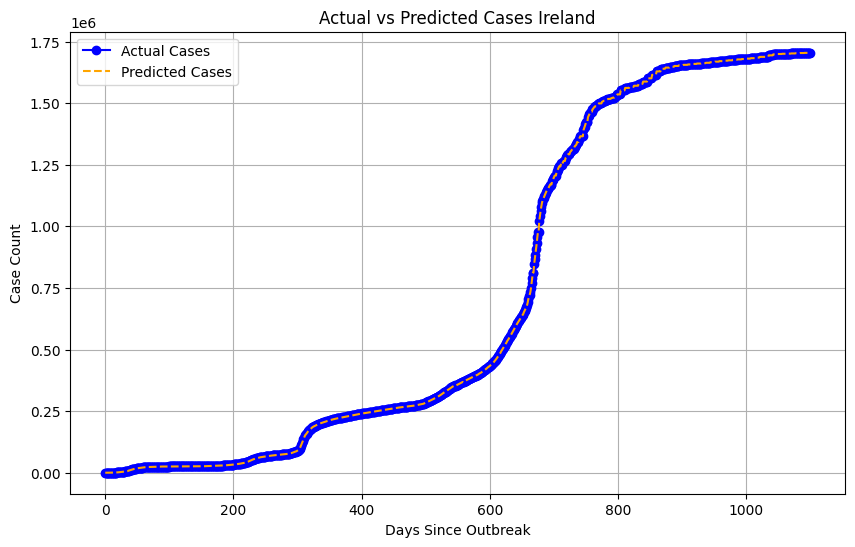

In [13]:
# visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ireland_df['cases'], label='Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['cases'], label='Predicted Cases', color='orange', linestyle='--')
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases Ireland')
plt.legend()
plt.grid(True)
plt.show()

# Question 2
Refer to the previous question. Let A and B be your two countries. Create a plot of time versus prediction error for the following: a. fit the model on (all of) A and apply it to (all of) A to get the mean squared error, b. fit A on the first half of the time for A, apply it to the second half of A to get the mean squared error.


In [49]:
## create country B (Russia)
# Filter for Russia
russia_df = coviddf_long[coviddf_long['Country/Region'] == 'Russia']

russia_df.head(100)
print(russia_df)

# Convert the 'date' column to a datetime object for easier handling
russia_df['date'] = pd.to_datetime(russia_df['date'])

# Filter to start at the first day with more than 0 cases
russia_df = russia_df[russia_df['cases'] > 0].reset_index(drop=True)

# Add a new column for t (days since the first case)
russia_df['t'] = (russia_df['date'] - russia_df['date'].min()).dt.days

# Display the processed DataFrame
print(russia_df)
# create lagged variables
for lag in range(1, 6):  # Create lags for the last 5 days
    russia_df[f'lag_{lag}'] = russia_df['cases'].shift(lag)

# Drop rows with NaN values caused by lagging
russia_df = russia_df.dropna().reset_index(drop=True)
from sklearn.linear_model import LinearRegression
import numpy as np


       Country/Region     date     cases
221            Russia  1/22/20         0
510            Russia  1/23/20         0
799            Russia  1/24/20         0
1088           Russia  1/25/20         0
1377           Russia  1/26/20         0
...               ...      ...       ...
329103         Russia   3/5/23  22029824
329392         Russia   3/6/23  22040875
329681         Russia   3/7/23  22051220
329970         Russia   3/8/23  22063473
330259         Russia   3/9/23  22075858

[1143 rows x 3 columns]
     Country/Region       date     cases     t
0            Russia 2020-01-31         2     0
1            Russia 2020-02-01         2     1
2            Russia 2020-02-02         2     2
3            Russia 2020-02-03         2     3
4            Russia 2020-02-04         2     4
...             ...        ...       ...   ...
1129         Russia 2023-03-05  22029824  1129
1130         Russia 2023-03-06  22040875  1130
1131         Russia 2023-03-07  22051220  1131
1132         

/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_20138/71242662.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  russia_df['date'] = pd.to_datetime(russia_df['date'])
/var/folders/41/_1xqwqw53djd233phgzw2_5w0000gn/T/ipykernel_20138/71242662.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russia_df['date'] = pd.to_datetime(russia_df['date'])


Intercept (α₀): 153.35229543969035
Coefficient for Y_t-1 (β1): 2.5672618921078474
Coefficient for Y_t-2 (β2): -2.3108890914385816
Coefficient for Y_t-3 (β3): 1.026688200669127
Coefficient for Y_t-4 (β4): -0.3949972966496366
Coefficient for Y_t-5 (β5): 0.11193136562422118


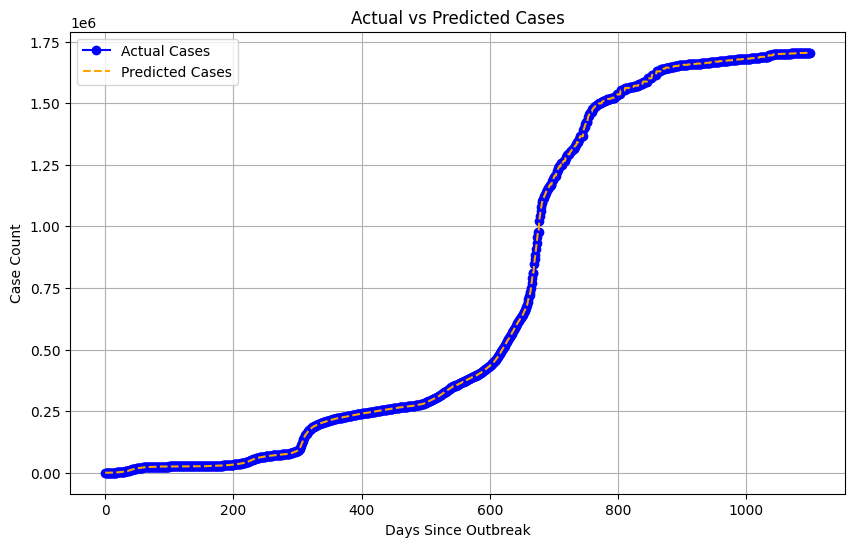

In [15]:
# Define the predictor variables (lags) and the target variable (current cases)
X = russia_df[[f'lag_{lag}' for lag in range(1, 6)]]
y = russia_df['cases']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept
intercept = model.intercept_
coefficients = model.coef_

# Print the results
print("Intercept (α₀):", intercept)
for i, coef in enumerate(coefficients, start=1):
    print(f"Coefficient for Y_t-{i} (β{i}):", coef)
# visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ireland_df['cases'], label='Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['cases'], label='Predicted Cases', color='orange', linestyle='--')
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.grid(True)
plt.show()


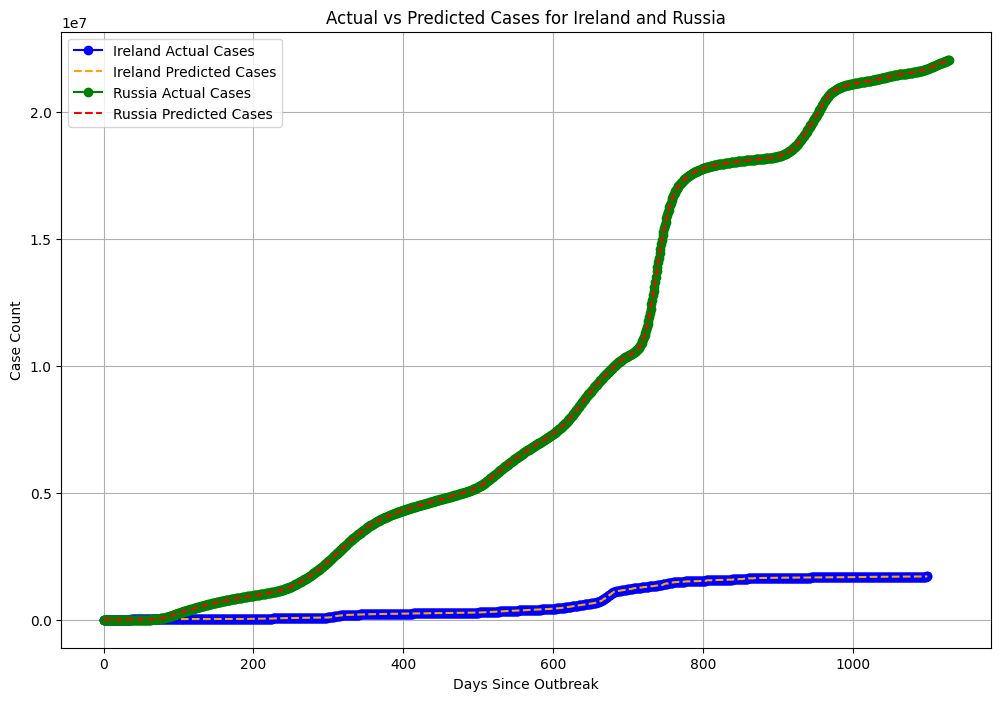

In [ ]:
# ireland and russia
import matplotlib.pyplot as plt

# Plot actual cases for both countries
plt.figure(figsize=(12, 8))
plt.plot(ireland_df['cases'], label='Ireland Actual Cases', color='blue', marker='o')
plt.plot(ireland_df['cases'], label='Ireland Predicted Cases', color='orange', linestyle='--')
plt.plot(russia_df['cases'], label='Russia Actual Cases', color='green', marker='o')
plt.plot(russia_df['cases'], label='Russia Predicted Cases', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Days Since Outbreak')
plt.ylabel('Case Count')
plt.title('Actual vs Predicted Cases for Ireland and Russia')
plt.legend()
plt.grid(True)
plt.show()

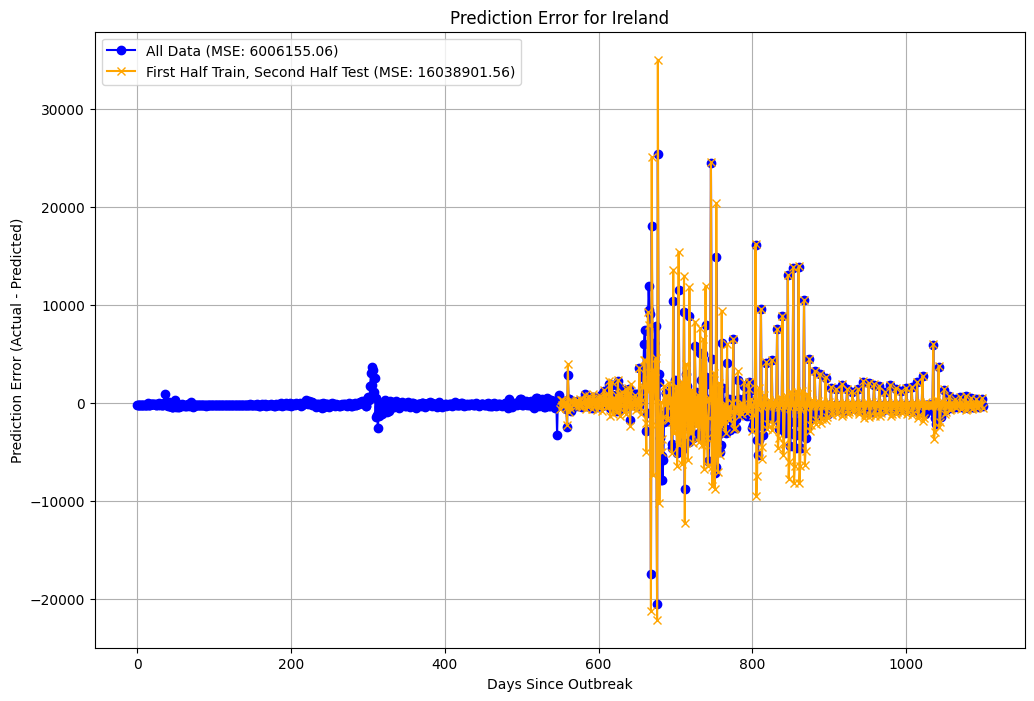

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function to calculate prediction error and MSE
def calculate_prediction_error(df, X_columns, y_column, train_indices, test_indices):
    # Split the data into training and testing sets
    X_train = df.loc[train_indices, X_columns]
    y_train = df.loc[train_indices, y_column]
    X_test = df.loc[test_indices, X_columns]
    y_test = df.loc[test_indices, y_column]
    
    # Fit the model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate prediction error and MSE
    prediction_error = y_test - y_pred
    mse = mean_squared_error(y_test, y_pred)
    
    return prediction_error, mse

# Define the lagged variables and target variable
X_columns = [f'lag_{lag}' for lag in range(1, 6)]
y_column = 'cases'

# Case a: Fit the model on all of Ireland's data
all_indices = ireland_df.index
prediction_error_all, mse_all = calculate_prediction_error(ireland_df, X_columns, y_column, all_indices, all_indices)

# Case b: Fit the model on the first half of Ireland's data and apply it to the second half
split_index = len(ireland_df) // 2
train_indices = ireland_df.index[:split_index]
test_indices = ireland_df.index[split_index:]
prediction_error_half, mse_half = calculate_prediction_error(ireland_df, X_columns, y_column, train_indices, test_indices)

# Plot the prediction errors
plt.figure(figsize=(12, 8))

# Plot prediction error for Case a
plt.plot(all_indices, prediction_error_all, label=f'All Data (MSE: {mse_all:.2f})', color='blue', marker='o')

# Plot prediction error for Case b
plt.plot(test_indices, prediction_error_half, label=f'First Half Train, Second Half Test (MSE: {mse_half:.2f})', color='orange', marker='x')

# Add labels, title, and legend
plt.xlabel('Days Since Outbreak')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.title('Prediction Error for Ireland')
plt.legend()
plt.grid(True)
plt.show()

                           Logit Regression Results                           
Dep. Variable:                      Z   No. Observations:                 1095
Model:                          Logit   Df Residuals:                     1089
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                  0.5148
Time:                        09:42:57   Log-Likelihood:                -312.46
converged:                       True   LL-Null:                       -643.92
Covariance Type:            nonrobust   LLR p-value:                5.074e-141
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3924      0.188    -12.692      0.000      -2.762      -2.023
Z_lag1         2.1423      0.242      8.851      0.000       1.668       2.617
Z_lag2         0.7130      0.282      2.528      0.0

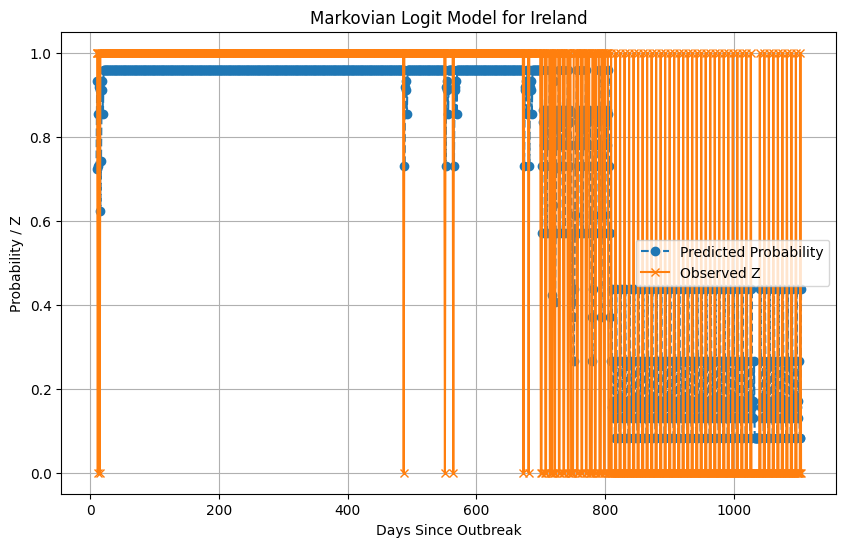

In [17]:
## question 4
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


# 1. bi Z_t：more than previous day，so Z_t = 1，else 0
ireland_df['Z'] = (ireland_df['cases'] > ireland_df['cases'].shift(1)).astype(int)
ireland_df = ireland_df.dropna(subset=['Z']).reset_index(drop=True)

for lag in range(1, 6):
    ireland_df[f'Z_lag{lag}'] = ireland_df['Z'].shift(lag)

ireland_model = ireland_df.dropna(subset=[f'Z_lag{lag}' for lag in range(1, 6)]).copy()

X = ireland_model[[f'Z_lag{lag}' for lag in range(1, 6)]]
X = sm.add_constant(X) 
y = ireland_model['Z']

logit_model = sm.Logit(y, X).fit(disp=False)
print(logit_model.summary())

ireland_model['pred_prob'] = logit_model.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(ireland_model['t'], ireland_model['pred_prob'], label='Predicted Probability', marker='o', linestyle='--')
plt.plot(ireland_model['t'], ireland_model['Z'], label='Observed Z', marker='x')
plt.xlabel('Days Since Outbreak')
plt.ylabel('Probability / Z')
plt.title('Markovian Logit Model for Ireland')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install requests pandas numpy statsmodels matplotlib scikit-learn
